In [1]:
from copy import deepcopy
import json
import time

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import dowhy
from dowhy import CausalModel

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML
from econml.dr import DRLearner, SparseLinearDRLearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

c:\Users\domen\AppData\Local\anaconda3\envs\causal-book\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\domen\AppData\Local\anaconda3\envs\causal-book\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

In [2]:
dowhy.__version__

'0.8'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 10



## Doubly Robust Methods: Let’s Get More!

In [5]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Read the data

In [6]:
# Train set
earnings_interaction_train = pd.read_csv(r'./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'./data/ml_earnings_interaction_test.csv')

In [7]:
earnings_interaction_train.shape, earnings_interaction_test.shape

In [8]:
# Train 
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [9]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


### Define the graph

In [10]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [11]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

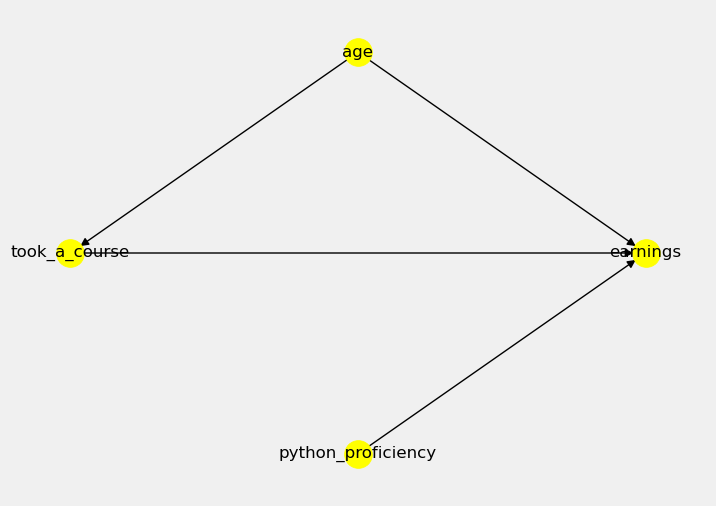

In [12]:
model.view_model()

### Get the estimand

In [13]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [14]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.LinearDRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    })

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 3
[LightGBM] [Info] Start training from score 143080.011600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [15]:
estimate.cate_estimates.mean()

In [16]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [17]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

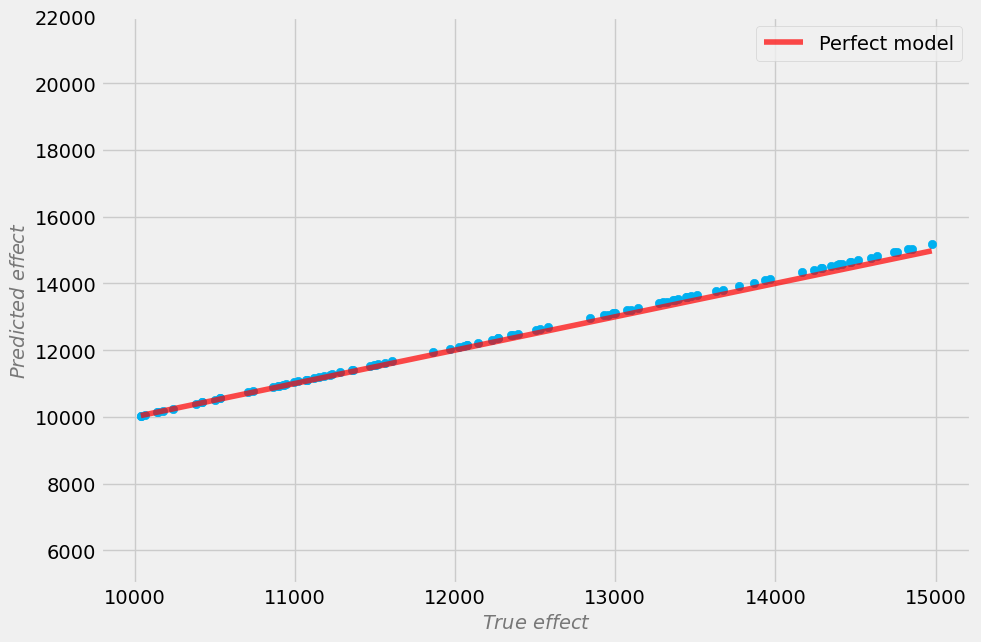

In [18]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### Non-linear DR

In [19]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10),
            'model_final': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 3
[LightGBM] [Info] Start training from score 142779.875600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [20]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [21]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

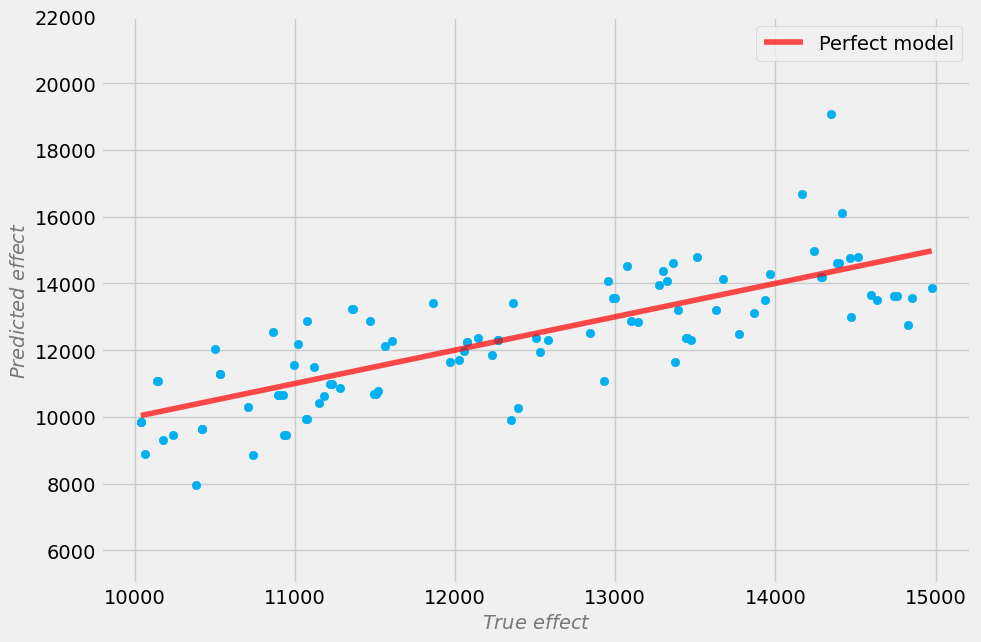

In [22]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## If Machine Learning is Cool, How About Double Machine Learning?

### Estimate the effect

In [23]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True
        },
        'fit_params': {}
    })

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 4
[LightGBM] [Info] Start training from score 143305.804800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [24]:
estimate.cate_estimates.mean()

### Predict on test data

In [25]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [26]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

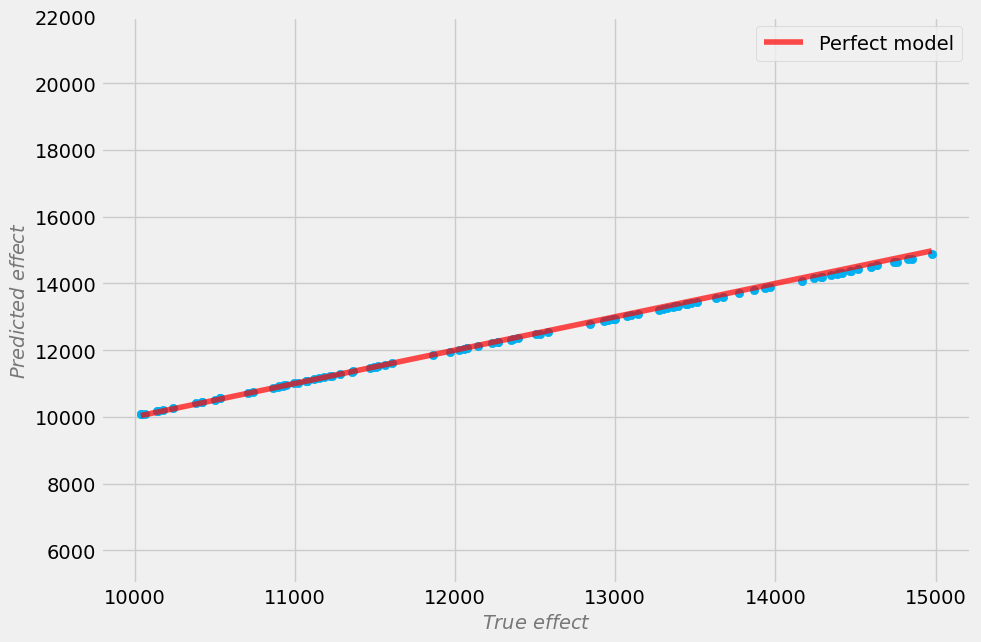

In [27]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### DML with more folds

In [28]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 4
[LightGBM] [Info] Start training from score 143164.349333
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

In [29]:
estimate.cate_estimates.mean()

In [30]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [31]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

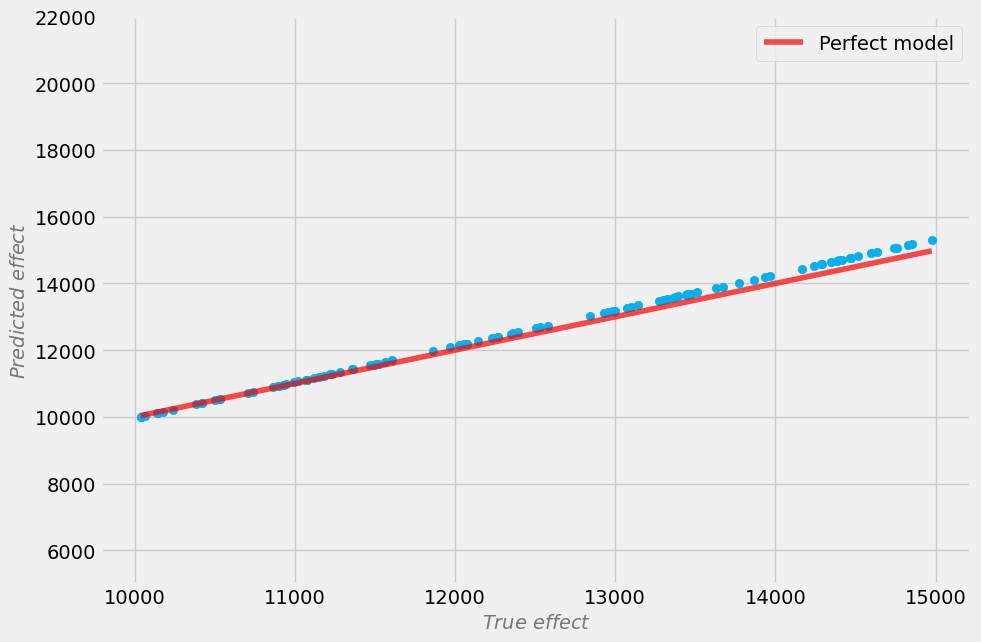

In [32]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### DML with cross-validation

In [33]:
# Define wrapped CV models
model_y = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
)

model_t = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='accuracy'
)

In [34]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': model_y,
            'model_t': model_t,
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Number of positive: 1476, number of negative: 2274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393600 -> initscore=-0.432205
[LightGBM] [Info] Start training from score -0.432205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [35]:
estimate.cate_estimates.mean()

In [36]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [37]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

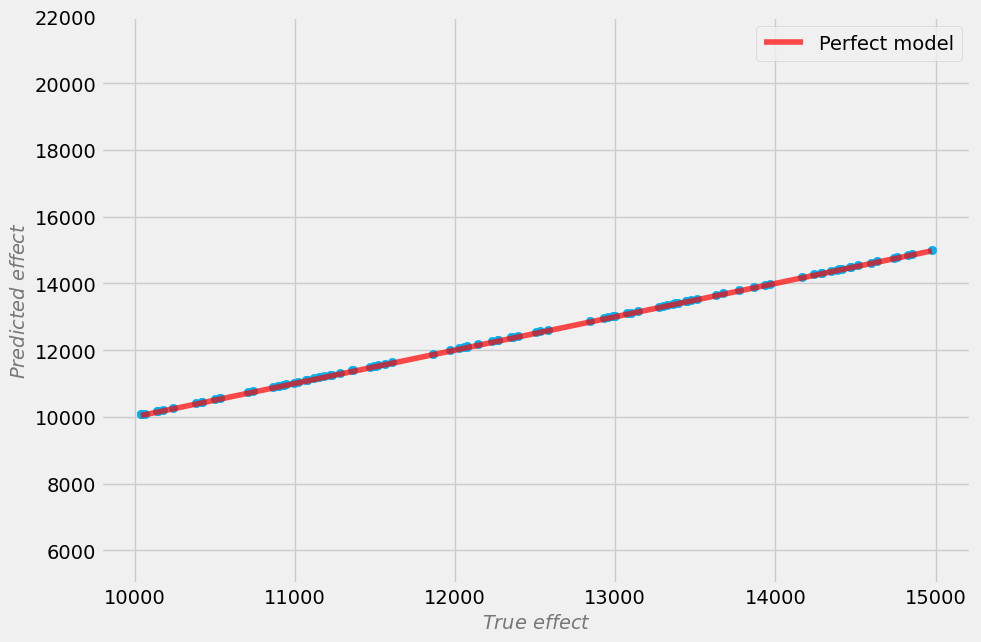

In [38]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Causal Forests and more

In [39]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.CausalForestDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LGBMClassifier(n_estimators=50, max_depth=10),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    }
)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1476, number of negative: 2274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393600 -> initscore=-0.432205
[LightGBM] [Info] Start training from score -0.432205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [40]:
estimate.cate_estimates.mean()

In [41]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [42]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

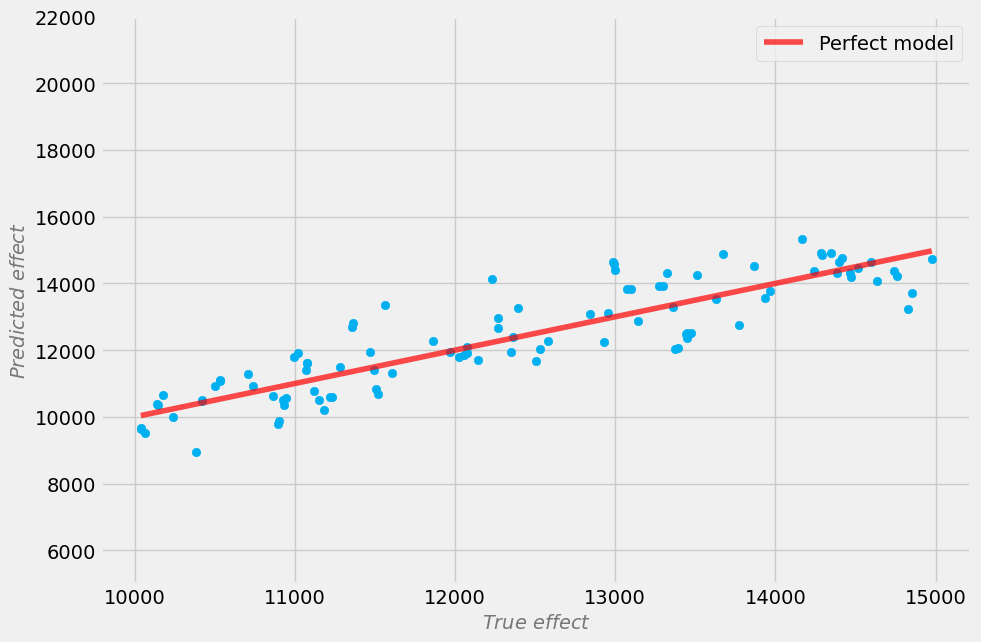

In [43]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Heterogenous Treatment Effects With Experimental Data (3 treatments)
* 1/3 cx received an email campaign featuring men's (t = 1)
* 1/3 cx received an email campaign featuring women's (t = 2)
* 1/3 cx received no campaign, control (t = 0)
* page 245

In [44]:
# Read in the data
hillstrom_clean = pd.read_csv(r'./data/hillstrom_clean.csv')

# Read in labels mapping
with open(r'./data/hillstrom_clean_label_mapping.json', 'r') as f:
    hillstrom_labels_mapping = json.load(f)

In [45]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,2
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,1


In [46]:
# Drop redundant cols to avoid multicollinearity
#... see page 246 for reasoning
hillstrom_clean = hillstrom_clean.drop(['zip_code__urban', 'channel__web'], axis=1)

### EDA

In [47]:
# Display mapping
hillstrom_labels_mapping

{'control': 0, 'womans_email': 1, 'mens_email': 2}

In [48]:
# P(visit)
hillstrom_clean.visit.mean()

In [49]:
# P(conversion)
hillstrom_clean.conversion.mean()

In [50]:
# Get sample size
sample_size = hillstrom_clean.shape[0]

In [51]:
# Check how random is the treatment assignment

# Split data
hillstrom_X = hillstrom_clean.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
hillstrom_Y = hillstrom_clean['spend']
hillstrom_T = hillstrom_clean['treatment']

In [52]:
# P(T=t)
hillstrom_T.value_counts() / sample_size

treatment
1    0.334172
2    0.332922
0    0.332906
Name: count, dtype: float64

##### Checking for randomness in RCT design
* Goal: if accuracy == split quality then success if not then we have a problem :)

In [53]:
# Train-test split
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(hillstrom_X, hillstrom_T, test_size=.5)

In [54]:
# Split quality
T_test_eda.value_counts() / T_test_eda.shape[0]

treatment
0    0.334531
1    0.334250
2    0.331219
Name: count, dtype: float64

In [56]:
# Fit the EDA model
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 9
[LightGBM] [Info] Start training from score -1.104788
[LightGBM] [Info] Start training from score -1.096334
[LightGBM] [Info] Start training from score -1.094745


LGBMClassifier()

In [58]:
# Get predictions on the test
T_pred_eda = lgbm_eda.predict(X_test_eda)

# Check accuracy
acc_eda = accuracy_score(T_test_eda, T_pred_eda)
acc_eda

##### Generate empirical confidence intervals

Generarting random data to create a distribution of matching scores && calculating the 95% confidence interval for these scores

In [68]:
np.random.choice([0, 1, 2], test_eda_sample_size)

array([1, 2, 0, ..., 2, 1, 2])

In [69]:
# Generate random data
#----

#... prepare for data generation
random_scores = []
n = 10000

#... count rows
test_eda_sample_size = T_test_eda.shape[0]

#... generates random choices (n times) from the set [0, 1, 2] using np.random
#...... it then compares these two sets of choices element-wise and calculates the mean of the resulting Boolean array. 
#...... this mean represents the proportion of elements that match between the two random sets.
for i in range(n):
    random_scores.append(
        (np.random.choice(
            [0, 1, 2], 
            test_eda_sample_size
            ) == np.random.choice(
            [0, 1, 2], 
            test_eda_sample_size)).mean())

#... calculate the 2.5th & 97.5th percentiles (to get boundaries for 95% CI)
np.quantile(random_scores, .025), np.quantile(random_scores, .975)

# ...get 95% CIs
lower = np.quantile(random_scores, .025)
upper = np.quantile(random_scores, .975)
lower, upper

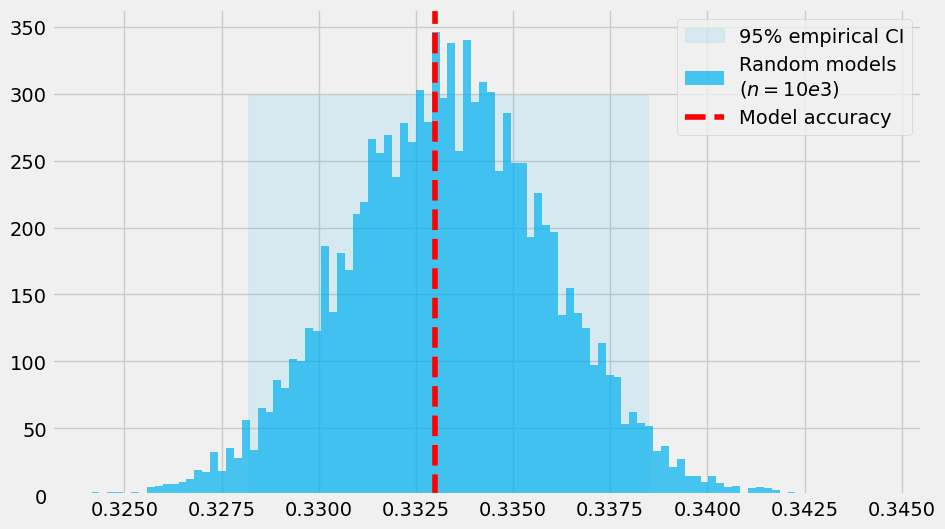

In [70]:
# Plot radom vs accuracy
plt.figure(figsize=(10, 6))
plt.fill_betweenx(
    x1=lower, 
    x2=upper, 
    y=np.arange(0, 300),
    color=COLORS[0],
    alpha=.1,
    label='95% empirical CI'
)
plt.hist(random_scores, alpha=.7, color=COLORS[0], bins=100, label='Random models\n($n=10e3$)')
plt.axvline(acc_eda, color=COLORS[1], ls='--', label='Model accuracy')

plt.legend()
plt.show()

##### Exploring distributions of the treatments
... spend == target var (14-day spend after receiving treatment)

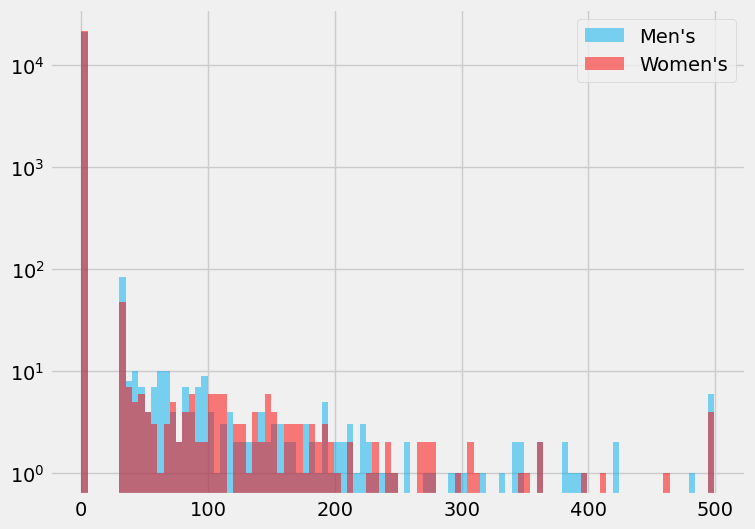

In [71]:
plt.figure(figsize=(8, 6))

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 2]['spend'], 
    label=f'Men\'s', 
    color=COLORS[0],
    bins=100, 
    alpha=.5)

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 1]['spend'], 
    label=f'Women\'s',
    color=COLORS[1],
    bins=100, 
    alpha=.5)

plt.legend()
plt.yscale('log')
plt.show()

In [74]:
# calculate variance
hillstrom_clean[hillstrom_clean['treatment'] == 1]['spend'].var()

In [75]:
hillstrom_labels_mapping

{'control': 0, 'womans_email': 1, 'mens_email': 2}

### Modeling Hillstrom
* for inspiration, see the winning submission for the challenge: [PDF saved in this repo](docs\hillstrom_radcliffe_submission.pdf)

In [94]:
# How many observations in our dataset converted?
cr_0 = (hillstrom_Y[hillstrom_T == 0] > 0).sum()
cr_1 = (hillstrom_Y[hillstrom_T == 1] > 0).sum()
cr_2 = (hillstrom_Y[hillstrom_T == 2] > 0).sum()
cr_t = (hillstrom_Y[hillstrom_T > 0] > 0).sum()
print(
  "conversion breakdown:", "\n", 
  f"- control, T=0: {cr_0}", "\n", 
  f"- treatment, T>0-: {(hillstrom_Y[hillstrom_T > 0] > 0).sum()}", "\n", 
  f"  - T=1: {cr_1}", "\n", 
  f"  - T=2: {cr_2}"
      )

conversion breakdown: 
 - control, T=0: 122 
 - treatment, T>0-: 456 
   - T=1: 189 
   - T=2: 267


#### Preprocess


In [82]:
# Train test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,
    test_size=0.5
)

In [83]:
# How many observations in train/test converted?
(y_train[T_train > 0] > 0).sum(), (y_test[T_test > 0] > 0).sum()

(212, 244)

#### Model training
* Definining algos
* Fitting models

Model definition
1. s-learner
2. t-learner
3. x-learner
4. dr-learner
5. linear dml
6. causal forest with dml

In [96]:
# Defaulting ALL algorithms to use LGBM
#... if continuous (regressor), use LGBMRegressor
#... if categorical (classifier), use LGBMClassifier
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == 'regressor':
        return LGBMRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    elif model_type == 'classifier':
        return LGBMClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate)
    else:
        raise NotImplementedError(f'Model type `{model_type}` not implemented.')

In [98]:
# Defining the 6 algos directly with EconML
s_learner = SLearner(
    overall_model=create_model('regressor')
)

x_learner = XLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ],
    cate_models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

t_learner = TLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)

dml = LinearDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model('regressor'),
    model_final=create_model('regressor'),
    cv=5,
)

cf = CausalForestDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

Fit estimators


In [101]:
# Store them in a dictionary
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
} 

# Fit the estimator
for model_name, model in models.items():
    start = time.time()
    print(f'Fitting {model_name}')
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train
    )
    stop = time.time()
    
    print(f'{model_name} fitted in {stop - start:0.4f} seconds.\n')

Fitting SLearner
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 12
[LightGBM] [Info] Start training from score 0.976246
SLearner fitted in 0.1964 seconds.

Fitting TLearner
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 10586, number of used features: 9
[LightGBM] [Info] Start training from score 0.659397
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 10671, number of used features: 9
[LightGBM] [Info] Start training from score 0.908519
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 25600, number of used features: 11
[LightGBM] [Info] Start training from score 0.952184
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set nu

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4902
[LightGBM] [Info] Number of data points in the train set: 25600, number of used features: 86
[LightGBM] [Info] Start training from score 1.035727
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set n

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 25600, number of used features: 9
[LightGBM] [Info] Start training from score 0.980691
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num

#### Model evaluation

In [106]:
# compute effects
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}

# computing treatment effects for different models on both training and test datasets
# ... note: tqdm is a library for adding progress bars to your loops
for treatment in [1, 2]:
    for model_name, model in tqdm(models.items()):
        
        # Compute effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f'treatment_{treatment}'][model_name] = effects_local_train
        
        # Compute effects on test
        effects_local_test = models[model_name].effect(X_test.values, T0=0, T1=treatment)
        effects_test[f'treatment_{treatment}'][model_name] = effects_local_test

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 17%|█▋        | 1/6 [00:00<00:02,  2.28it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 33%|███▎      | 2/6 [00:00<00:01,  2.07it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

 50%|█████     | 3/6 [00:01<00:02,  1.44it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 67%|██████▋   | 4/6 [00:02<00:01,  1.81it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 17%|█▋        | 1/6 [00:00<00:02,  1.87it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 33%|███▎      | 2/6 [00:01<00:02,  1.98it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

 50%|█████     | 3/6 [00:01<00:01,  1.69it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 67%|██████▋   | 4/6 [00:02<00:00,  2.12it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


100%|██████████| 6/6 [00:02<00:00,  2.17it/s]


Calculate Uplift by decile

In [120]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):
    
    # Encapsulate the data & sort according to uplifts
    all_data = pd.DataFrame(
        dict(
            uplifts=uplifts, 
            y_true=y_true, 
            t_true=t_true)
    ).query(f't_true==0 | t_true=={t_pred}').sort_values('uplifts')
    
    # Partition into deciles
    all_data['deciles'] = pd.cut(all_data['uplifts'], bins=10, labels=np.arange(10), duplicates='raise')
    
    # Get mean responses within deciles
    mean_decile_resp = all_data.groupby(['deciles', 't_true']).mean()
    
    # Compute true decile uplift
    mean_decile_resp['true_uplift'] = mean_decile_resp['y_true'] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0]).sum()['true_uplift']  
    
    return true_uplift[::-1]


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

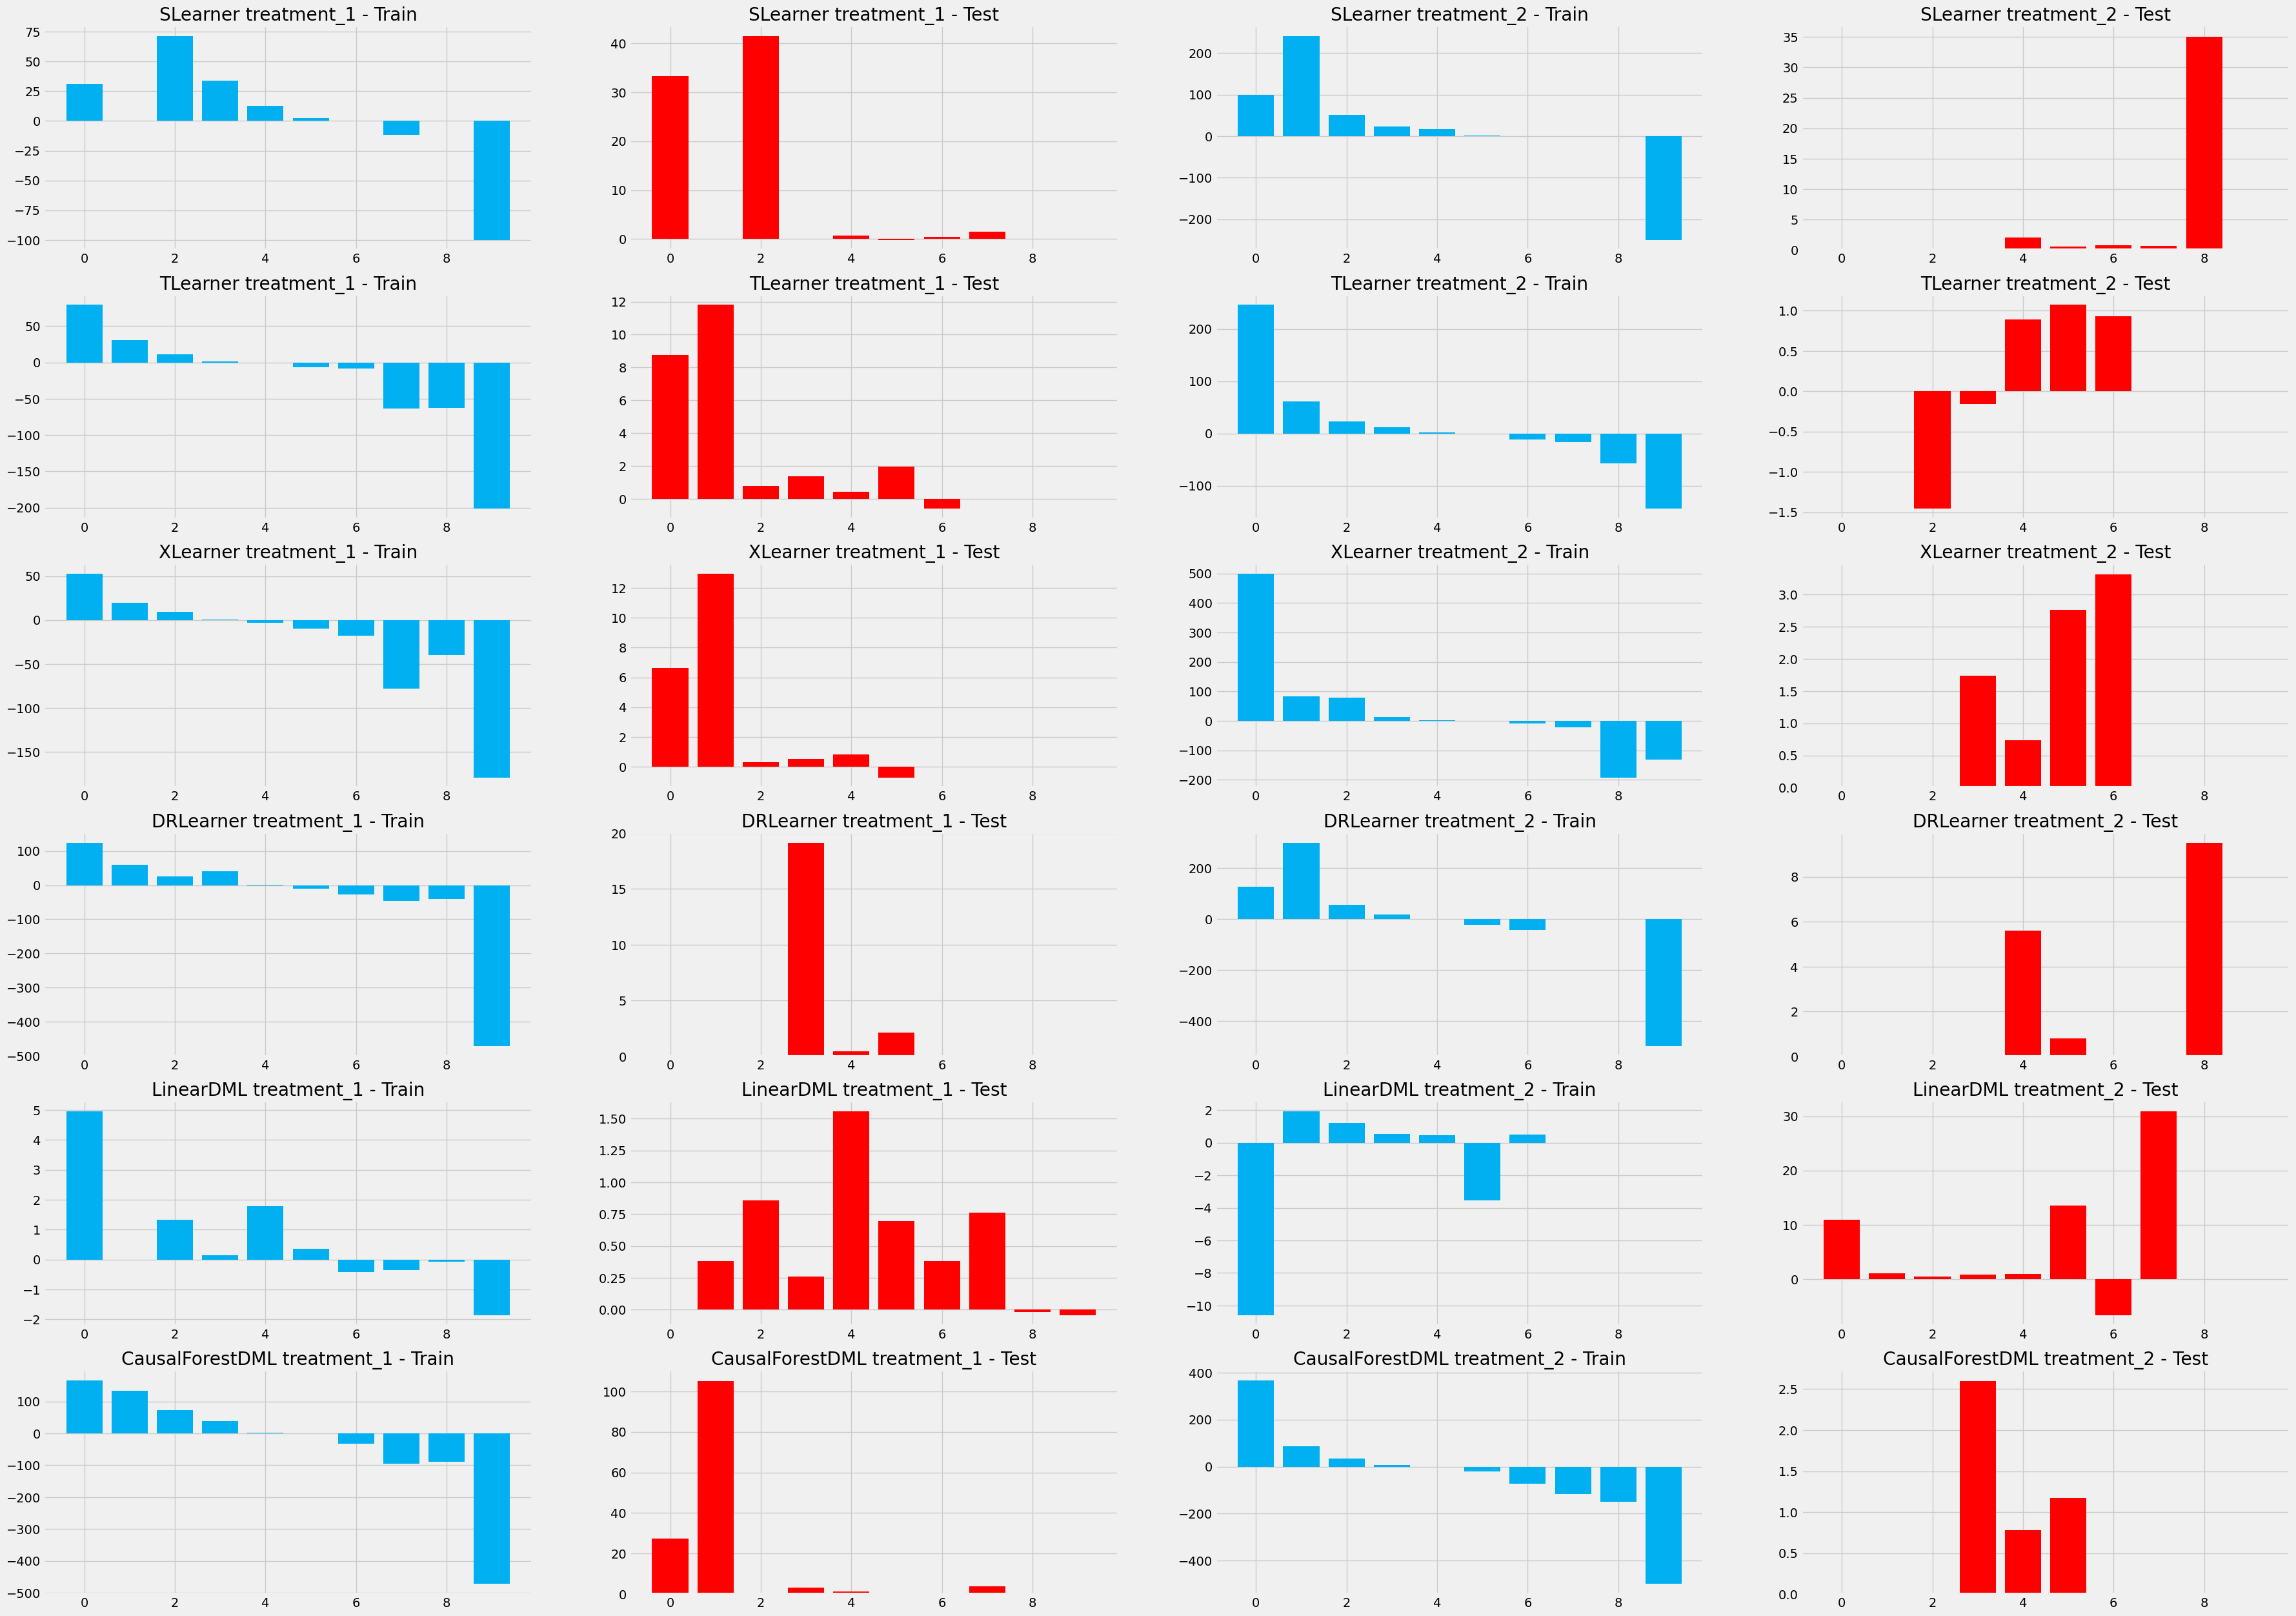

In [125]:
# Below, we plot the uplift by decile
# ... the poor performance might on the test set might be due to overfitting, or the need to hyperparameter tune

plt.figure(figsize=(40, 30))

i = 1

for model_name in models.keys():
    
    uplifts_by_decile = {
        'treatment_1': {},
        'treatment_2': {}
    }
    
    global_min = np.inf
    global_max = -np.inf
    
    for treatment in ['treatment_1', 'treatment_2']:

        uplift_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name], 
            t_true=T_train,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_train
        )

        uplift_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name], 
            t_true=T_test,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_test
        )
            
        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplift_by_decile_train, color=COLORS[0])
        plt.title(f'{model_name} {treatment} - Train')
        
        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplift_by_decile_test, color=COLORS[1])
        plt.title(f'{model_name} {treatment} - Test')
        
        i += 2
        
plt.show()

##### Expected response

As introduced by [Zhao et al., 2017](https://arxiv.org/pdf/1705.08492.pdf)

Formula:

$$\Large Z = \sum_{t=0}^K \frac{1}{P(T=t)}y \mathbb{I}_{h(x)=t}\mathbb{I}_{T=t}$$

<br>


* $K$ is a number of treatment levels

* $\mathbb{I}$ is an indicator function

* $h(x)$ is the treatment recommended by the model (treatment leading to the highest uplift)

In [122]:
def get_effects_argmax(effects_arrays, return_matrix=False):
    """Returns argmax for each row of predicted effects for the arbitrary no. of treatments.
    
    :param effects_arrays: A list of arrays for K treatments, where K>=1 (without control null effects)
    :type effects_arrays: list of np.arrays
    
    :param return_matrix: Determines if the function returns a matrix of all effects 
        (with added null effect for control)
    :type return_matrix: bool

    ...
    :return: A stacked matrix of all effects with added column for control effects (which is always 0)
    :rtype: np.array
    """
    
    n_rows = effects_arrays[0].shape[0]
    null_effect_array = np.zeros(n_rows)
    stacked = np.stack([null_effect_array] + effects_arrays).T
    
    if return_matrix:
        return np.argmax(stacked, axis=1), stacked
    
    return np.argmax(stacked, axis=1)


def get_expected_response(y_true, t_true, effects_argmax):
    """Computes the average expected response for an uplift model according to the formula
        proposed by: 
        Zhao, Y., Fang, X., & Simchi-Levi, D. (2017). Uplift Modeling with Multiple Treatments and General Response Types. 
        Proceedings of the 2017 SIAM International Conference on Data Mining, 588-596. 
        Society for Industrial and Applied Mathematics.   
    """
    
    proba_t = pd.Series(t_true).value_counts() / np.array(t_true).shape[0]
    treatments = proba_t.index.values
    
    z_vals = 0
    
    for treatment in treatments:
        h_indicator = effects_argmax == treatment
        t_indicator = t_true == treatment
        t_proba_local = proba_t[treatment]
        
        z_vals += (1/t_proba_local) * y_true * h_indicator * t_indicator
    
    return z_vals.mean()

In [126]:
# Compute expected response (higher = better)
print('Expecetd response on train:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_train['treatment_1'][model_name],
            effects_train['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_train, 
        t_true=T_train, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')
    
print('\n' + '-'*30)
    
print('Expected response on test:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_test['treatment_1'][model_name],
            effects_test['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_test, 
        t_true=T_test, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')

Expecetd response on train:

SLearner: 1.9614855107561
TLearner: 2.5231151305296184
XLearner: 2.4140384283440337
DRLearner: 2.3331755658969393
LinearDML: 1.5747582624032939
CausalForestDML: 2.816927274799632

------------------------------
Expected response on test:

SLearner: 1.3546409065690905
TLearner: 1.4633895110591675
XLearner: 1.3464883019550835
DRLearner: 1.4758118330459733
LinearDML: 1.5132410239430591
CausalForestDML: 1.3727850056435942


In [124]:
# Outcome in the whole dataset
hillstrom_clean.groupby('treatment')['spend'].mean()

treatment
0    0.652789
1    1.077202
2    1.422617
Name: spend, dtype: float64

##### Confidence intervals

In [127]:
# Linear DML confidence intervals
models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1)

(array([-2.74129871, -1.32409202, -0.16944133, ..., -0.77253949,
        -1.76521849,  0.01785051]),
 array([4.25921767e+00, 1.04879920e-01, 1.38880953e+00, ...,
        1.77023714e+00, 3.77166603e-03, 2.11006075e+00]))

In [128]:
models['LinearDML'].effect_interval(X=X_test.iloc[0:1, :], T0=0, T1=1)

(array([-2.74129871]), array([4.25921767]))

In [130]:
# CIs (DML)
ints = np.stack(models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1, alpha=.05)).T

# What % of effects contains zero?
(np.sign(ints[:, 0]) == np.sign(ints[:, 1])).sum() / ints.shape[0]